In [4]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

from IPython.display import clear_output
import matplotlib.pyplot as plt

import segmentation_models as sm

import tensorflow_addons as tfa
import cv2
import numpy as np
import matplotlib
from matplotlib import pyplot
from matplotlib.image import imread

2.2.0


In [6]:
def display(display_list, idx=None, only_inference=False, fig_size=15):
    """
    "only_inference" = True creates sample of inferenced image PNG file.
    """
    if only_inference:
        plt.figure(figsize=(fig_size,fig_size))
        #a = np.array(display_list)
        #a = a.astype(np.float32) * 255.0
        plt.imshow(display_list)
        plt.axis('off')
        plt.show()

        #cv2.imwrite("EX{}.png".format(idx), cv2.cvtColor(a, cv2.COLOR_RGB2BGR))
    
    else:
        plt.figure(figsize=(fig_size,fig_size))
        title = ['Input', 'True', 'Predcited']

        for i in range(len(display_list)):
            plt.subplot(1, len(display_list), i+1)
            plt.title(title[i])
            plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
            plt.axis('off')

        plt.show()
    

In [7]:
def create_mask(pred_mask, num=0):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[num]

def show_predictions(test_mode=False, x=None,y=None, num=1):
  if test_mode:
    print("In testing Mode...")
    for i in range(num):
      pred_mask = model.predict(x, batch_size=1)
      display([x[i], y[i], create_mask(pred_mask, num=i)])

  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [25]:
#Compile Options
ACTIVATION = "softmax"
FROM_LOGITS = False 
OPTIMIZER = "RMSprop" 
LR = 0.001 #0.0001
ENC_FREEZE = False
BACKBONE = 'inceptionv3'

#Fit options
EPOCHS = 100
BATCH_SIZE = 2
NUM_VAL = 20
F_EPOCHS = 20

#Other
IMG_SIZE = (1200,1392) #   #1200, 1392 70s #960, 1152 #480 576 #Image size must be multiples of 48 to support segmentation models (PSPNET)
STEPS_PER_EPOCH = 30

In [9]:
def onehot_to_rgb(one_hot):

    channel_0 = np.zeros(IMG_SIZE + (1,)) #prediction
    channel_1 = np.zeros(IMG_SIZE + (1,))
    channel_2 = np.zeros(IMG_SIZE + (1,))
    
    ex = one_hot # ex = H,W,1

    #pushed = tf.expand_dims(ex[:,:,1], -1) + tf.expand_dims(ex[:,:,2], -1)
    #circle = tf.expand_dims(ex[:,:,3], -1)
    #stamped = tf.expand_dims(ex[:,:,2], -1) # stamped = H,W,1
    #bg = tf.expand_dims(ex[:,:,0], -1)
    #hole = tf.expand_dims(ex[:,:,4], -1)

    channel_0[ex==1] = color_dict[1][0]
    channel_1[ex==1] = color_dict[1][1]
    channel_2[ex==1] = color_dict[1][2]

    channel_0[ex==3] = color_dict[3][0]
    channel_1[ex==3] = color_dict[3][1]
    channel_2[ex==3] = color_dict[3][2]

    channel_0[ex==2] = color_dict[2][0]
    channel_1[ex==2] = color_dict[2][1]
    channel_2[ex==2] = color_dict[2][2]

    channel_0[ex==0] = color_dict[0][0]
    channel_1[ex==0] = color_dict[0][1]
    channel_2[ex==0] = color_dict[0][2]
    
    channel_0[ex==4] = color_dict[4][0]
    channel_1[ex==4] = color_dict[4][1]
    channel_2[ex==4] = color_dict[4][2]
    
    channel_0[ex==5] = color_dict[5][0]
    channel_1[ex==5] = color_dict[5][1]
    channel_2[ex==5] = color_dict[5][2]
    

    com = tf.concat([channel_0, channel_1, channel_2], -1)

    display(com, only_inference=True,fig_size=10)

Get One sample & get unique colors

In [10]:
mask = imread('Mask_Image/[2021-10-13]11.25.55.086_1_2_Image.png') #2048 x 2448
colors = np.unique(tf.reshape(mask,[-1,3]), axis=0)

In [11]:
color_dict = {i: list(x) for i,x in enumerate(colors)}

print(color_dict)
#1,1,0: Yellow 0,1,0 Green 101 pink, 000b 011 cyan 100 Red 
# 0 bg, 1 Circle 2 hole 3 small 4 stamp 5 psuhed 

def rgb_to_onehot(rgb_arr, color_dict):
    num_classes = len(color_dict)
    shape = rgb_arr.shape[:2] + (num_classes,)
    arr = np.zeros(shape, dtype=np.int32)
    for i, cls in enumerate(color_dict):
        arr[:, :, i] = np.all(rgb_arr.reshape((-1, 3)) == color_dict[i], axis=1).reshape(shape[:2])
    return arr

{0: [0.0, 0.0, 0.0], 1: [0.0, 1.0, 0.0], 2: [0.0, 1.0, 1.0], 3: [1.0, 0.0, 1.0], 4: [1.0, 0.23529412, 0.23529412], 5: [1.0, 1.0, 0.0]}


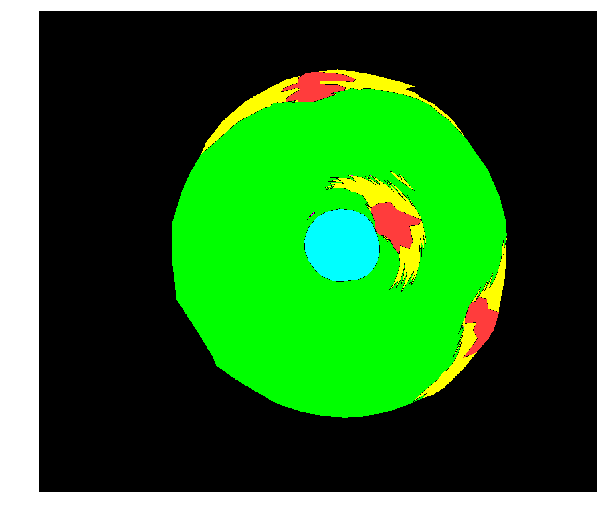

In [12]:
a = rgb_to_onehot(mask,color_dict)

bb = tf.expand_dims(np.argmax(a, axis=-1),-1)
bbb = tf.image.resize(bb, IMG_SIZE) #480, 576 960,1152

#ccc = tf.image.flip_left_right(bbb)
angle = np.random.uniform(0,2*np.pi)
ccc = tfa.image.rotate(bbb, angle)

#display([bbb, ccc])

onehot_to_rgb(bbb)

Preprocess train images/masks:
  1. resize both
  2. for x, convert to rgb
  3. for mask, convert to one hot?
  4. for both, apply augmentation (optional)

  Note: mask in png format, img in bmp format


In [19]:
import glob
import cv2
train_x = []
train_y = []

for img in glob.glob("Original_Image/*.png"):
    
    #angles to rotate
    angles = np.random.uniform(0, 2*np.pi, 3)
    
    #Image
    n = cv2.imread(img)
    n = tf.cast(n, tf.float32) / 255.0
    n = tf.image.resize(n, IMG_SIZE) #480, 576
    n = tf.image.rgb_to_grayscale(n)

    flipped_img = tfa.image.rotate(n, angles[0])
    flipped_img1 = tfa.image.rotate(n, angles[1])
    #flipped_img2 = tfa.image.rotate(n, angles[2])
    
    train_x.append(n)
    train_x.append(flipped_img)
    train_x.append(flipped_img1)
    #train_x.append(flipped_img2)

    #GET FILE NAME
    dir = "Mask_Image/" # "/".join(img.split("/")[:-1]) + "/Mask_Image/"
    file_name = img.split("/")[-1] # img.split("/")[-1].split('.')[0]

    #MASK
    y = imread(dir+file_name) # imread(dir+file_name+".png")
    a = rgb_to_onehot(y, color_dict) #change to one hot

    bb = tf.expand_dims(np.argmax(a, axis=-1),-1) #combine one hot
    mask = tf.image.resize(bb, IMG_SIZE)

    flipped_mask = tfa.image.rotate(mask, angles[0])
    flipped_mask1 = tfa.image.rotate(mask, angles[1])
    #flipped_mask2 = tfa.image.rotate(mask, angles[2])

    train_y.append(mask)
    train_y.append(flipped_mask)
    train_y.append(flipped_mask1)
    #train_y.append(flipped_mask2)

train_x = tf.convert_to_tensor(train_x)
train_y = tf.convert_to_tensor(train_y)

print(train_x.shape, np.max(train_x))
print(train_y.shape, np.max(train_y))

(240, 1200, 1392, 1) 0.99990004
(240, 1200, 1392, 1) 5.0


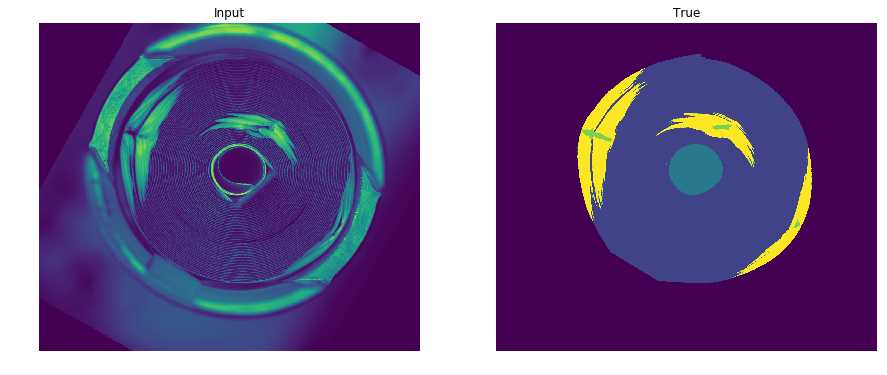

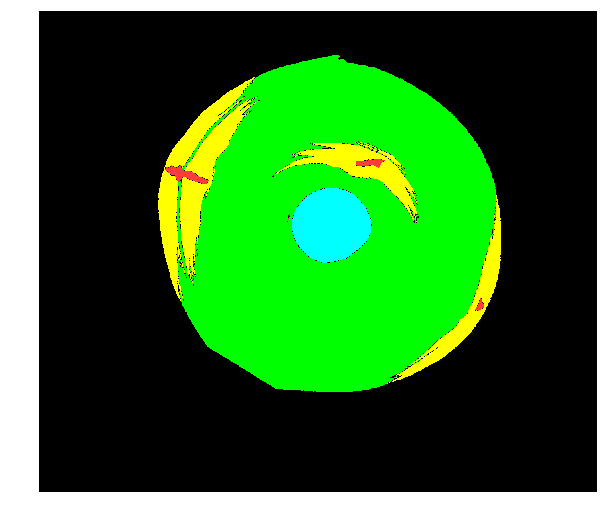

In [22]:
display([train_x[25], train_y[25]])
onehot_to_rgb(train_y[25])

In [23]:
sample_image = train_x[25]
sample_mask = train_y[25] 

찍힘 class에 가장 높은 weight, "눌림" class에 그 다음 높은 weight 적용

In [24]:
# 0 shows background, 1shows hole 2 shows "pushed", 3shows "Stamped", 4shows inner circle

# 0 bg, 1 Circle 2 hole 3 small 4 stamp 5 psuhed 

sample_weights = np.zeros(train_y.shape)

bg_count = (np.array(train_y)==0).sum()
stamp_count = (np.array(train_y)==4).sum()
hole_count = (np.array(train_y)==2).sum()
push_count = (np.array(train_y)==5).sum()
circle_count = (np.array(train_y)==1).sum()
small_count = (np.array(train_y)==3).sum()

denom = bg_count+circle_count+push_count+stamp_count+hole_count+small_count

CLASS_WEIGHT = [(denom/bg_count).round(), (denom/circle_count).round(), (denom/hole_count).round(), 
                (denom/small_count).round(), (denom/stamp_count).round(), (denom/push_count).round() ]


#CLASS_WEIGHT[2] = 3
#CLASS_WEIGHT[3] = 10
#CLASS_WEIGHT[4] = 5

# your own weight corresponding here:
sample_weights[train_y==0] = CLASS_WEIGHT[0]                                                                                                        
sample_weights[train_y==1] = CLASS_WEIGHT[1]                                                                                                               
sample_weights[train_y==2] = CLASS_WEIGHT[2]                                                                                                             
sample_weights[train_y==3] = CLASS_WEIGHT[3]   
sample_weights[train_y==4] = CLASS_WEIGHT[4]   
sample_weights[train_y==5] = CLASS_WEIGHT[5]   
print(CLASS_WEIGHT)

[1.0, 3.0, 62.0, 32960.0, 464.0, 42.0]


In [26]:
print(sample_weights.shape)
print(train_x.shape, train_y.shape)
BUFFER_SIZE = train_x.shape[0]

train_ds= tf.data.Dataset.from_tensor_slices((train_x[NUM_VAL:], train_y[NUM_VAL:]))#, sample_weights[NUM_VAL:]))
train_ds = train_ds.shuffle(buffer_size = BUFFER_SIZE-NUM_VAL).batch(BATCH_SIZE)

val_ds= tf.data.Dataset.from_tensor_slices((train_x[:NUM_VAL], train_y[:NUM_VAL]))#, sample_weights[:NUM_VAL]))
val_ds = val_ds.shuffle(buffer_size = NUM_VAL).batch(BATCH_SIZE)

(240, 1200, 1392, 1)
(240, 1200, 1392, 1) (240, 1200, 1392, 1)


Define Backbone model as well as segmentation model

In [27]:
sm.set_framework('tf.keras')
sm.framework()

if OPTIMIZER == "Adam":
    opt = keras.optimizers.Adam(learning_rate=LR) #default 0.001
elif OPTIMIZER == "RMSprop":
    opt = keras.optimizers.RMSprop(lr=LR) #default 0.001


model = sm.PSPNet(BACKBONE, input_shape = IMG_SIZE + (1,), classes=6, encoder_weights=None, 
                  activation=ACTIVATION, encoder_freeze = ENC_FREEZE)

model.compile(
    optimizer = opt,
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=FROM_LOGITS), 
    metrics=['accuracy'], 
)

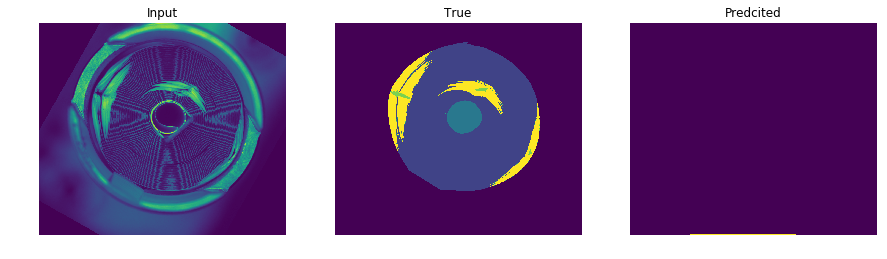

In [28]:
show_predictions()

In [29]:
import gc
import os
import datetime

#logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

gc.collect()

class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('{}에포크 이후의 예측 예시'.format(epoch+1))
    print ( 'Training Specifics: LR: {}, Validation size: {}, Image size: {}.'.format(LR, NUM_VAL,IMG_SIZE))
    print ('Current Accuracy: {}'.format(logs['accuracy']))
    print ('Validation Accuracy: {}'.format(logs['val_accuracy']))
    #tensorboard_callback
    gc.collect()
    

For 960 1152 image size, works upto total 140 images.
(480,576) 3 augs
(960, 1152) 3 augs (46*4 image usued for training.)
(1440, 1920) no augmentations applied Batch size = 2 for all cases(46images used for training.)
(1200, x) works for 2augs,  with B=2 !

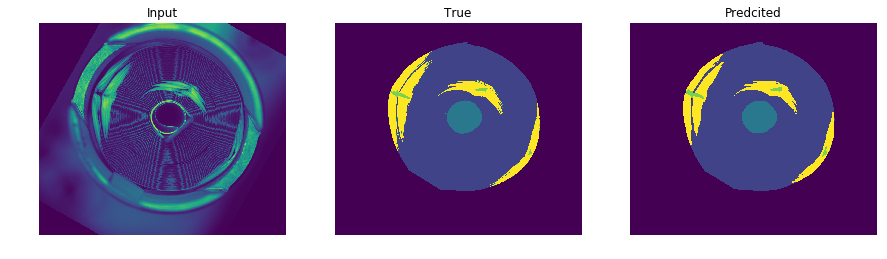

100에포크 이후의 예측 예시
Training Specifics: LR: 0.001, Validation size: 20, Image size: (1200, 1392).
Current Accuracy: 0.9942170977592468
Validation Accuracy: 0.994979977607727
110/110 [==============================] - 34s 307ms/step - loss: 0.0143 - accuracy: 0.9942 - val_loss: 0.0148 - val_accuracy: 0.9950


In [30]:
model_history = model.fit(train_ds, 
                          epochs=EPOCHS,
                          validation_data = val_ds,
                          callbacks=[DisplayCallback()],)                               

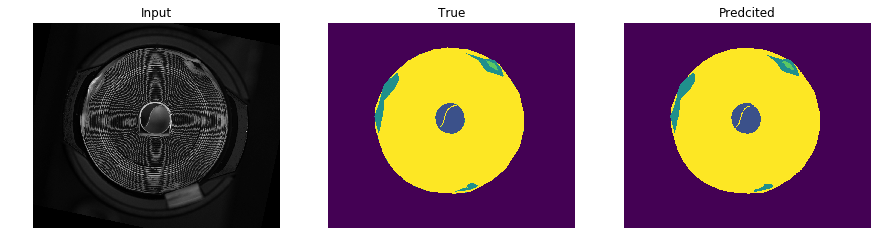

87에포크 이후의 예측 예시
Training Specifics: LR: 0.001, Validation size: 10, Image size: (960, 1152).
Current Accuracy: 0.9960302114486694
Validation Accuracy: 0.9871058464050293
20/30 [===================>..........] - 10s 494ms/step - loss: 0.0105 - accuracy: 0.9960 - val_loss: 0.0733 - val_accuracy: 0.9871


In [105]:
"""
model_history = model.fit(x= train_x[:130],
                          y= train_y[:130], 
                          batch_size = BATCH,
                          steps_per_epoch = STEPS_PER_EPOCH,
                          epochs=EPOCHS,
                          validation_data = (train_x[130:140], train_y[130:140]),#, sample_weights[100:110]),
                          callbacks=[DisplayCallback()],)
                          #sample_weight=sample_weights[110:])      
"""

In [19]:
"""sorc 4 40 40, inf 2 35 45, bd 5 40 42, gs 5 41 41
categs: lk, pow, jam, 5,45,50
%load_ext tensorboard
%tensorboard --logdir logs
from tensorboard import notebook
notebook.list() # View open TensorBoard instances
notebook.display(port=6006, height=1000) 
"""

'\n%load_ext tensorboard\n%tensorboard --logdir logs\nfrom tensorboard import notebook\nnotebook.list() # View open TensorBoard instances\nnotebook.display(port=6006, height=1000) \n'

In [36]:
test_x = []
test_y = []

for idx, img in enumerate(glob.glob("Original_Image/*.png")):

    n = cv2.imread(img)
    n = tf.cast(n, tf.float32) / 255.0
    n = tf.image.resize(n, IMG_SIZE)
    n = tf.image.rgb_to_grayscale(n)
    
    n = tf.image.flip_left_right(n)
    
    test_x.append(n)

    #GET FILE NAME
    dir = "Mask_Image/" 
    file_name = img.split("/")[-1] 

    #MASK
    y = imread(dir+file_name)
    a = rgb_to_onehot(y, color_dict) #change to one hot

    bb = tf.expand_dims(np.argmax(a, axis=-1),-1) #combine one hot
    bbb = tf.image.resize(bb, IMG_SIZE)
    bbb = tf.image.flip_left_right(bbb)
    
    test_y.append(bbb)
    
    if idx == 50: break

test_x = tf.convert_to_tensor(test_x)
test_y = tf.convert_to_tensor(test_y)

print(test_x.shape)
print(test_y.shape)

(51, 1200, 1392, 1)
(51, 1200, 1392, 1)


In testing Mode...


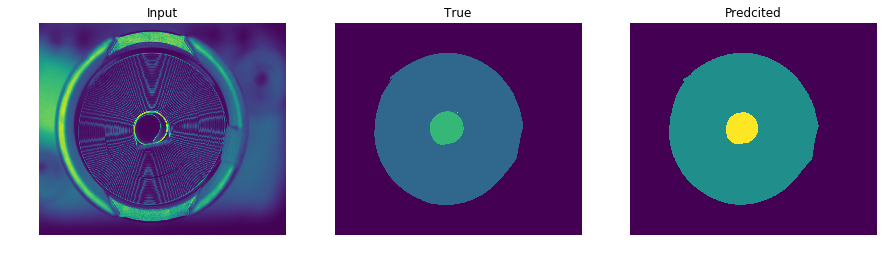

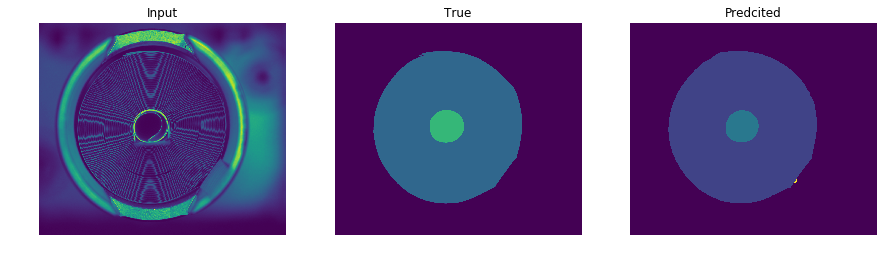

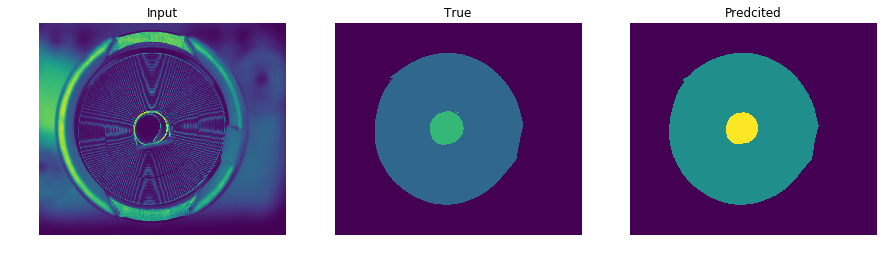

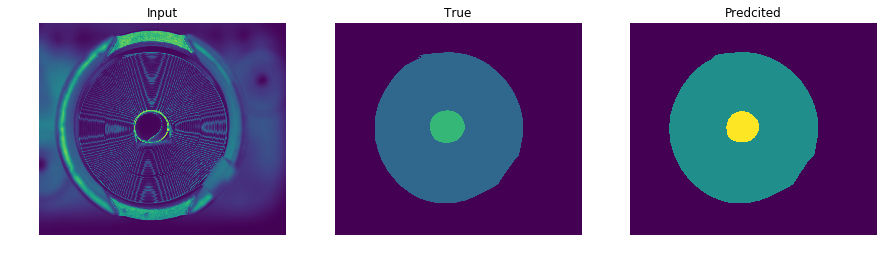

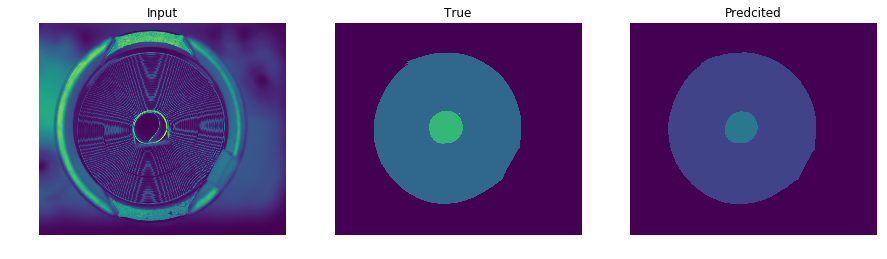

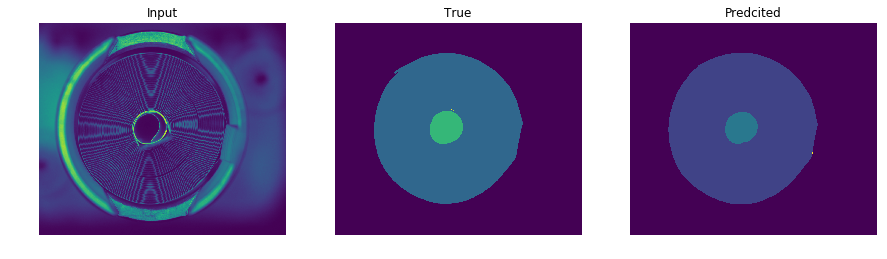

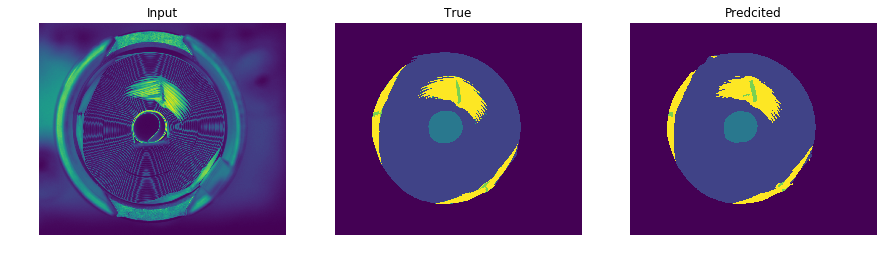

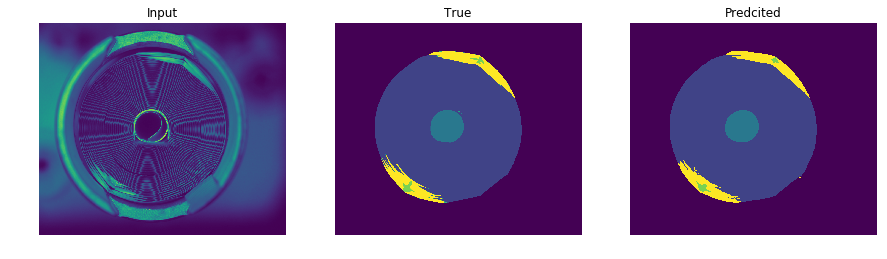

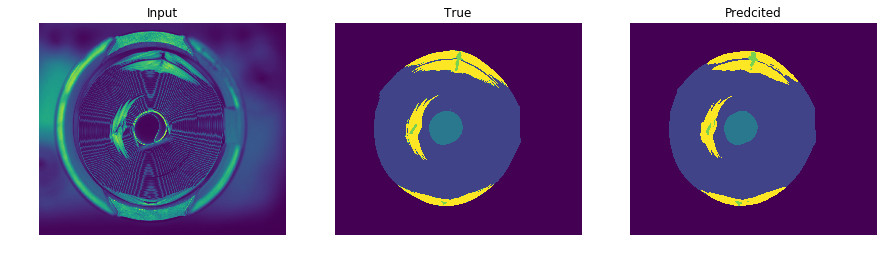

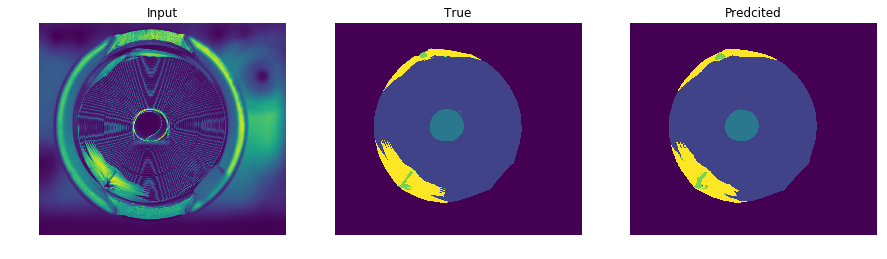

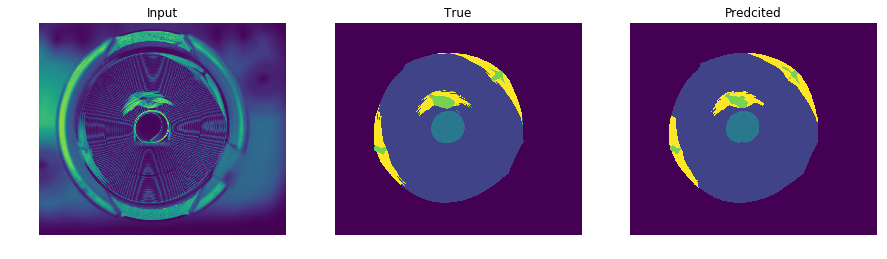

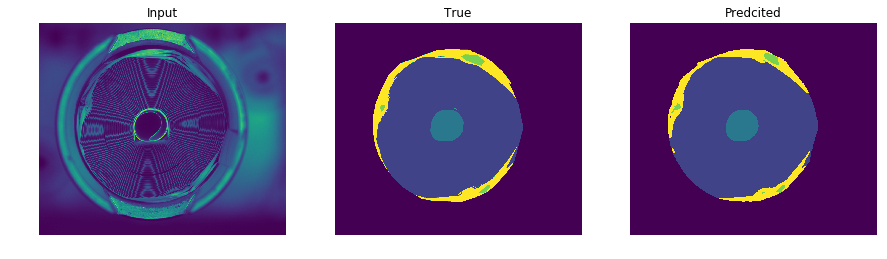

KeyboardInterrupt: 

In [37]:
show_predictions(test_mode=True, x=test_x, y=test_y, num=50)

Finetuning with smaller learning rate (make whole model trainable)



In [42]:
model.trainable = True

if OPTIMIZER == "Adam":
    opt = keras.optimizers.Adam(learning_rate=LR/10) #default 0.001
elif OPTIMIZER == "RMSprop":
    opt = keras.optimizers.RMSprop(lr=LR/10) #default 0.001

model.compile(
    optimizer = opt,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=FROM_LOGITS), 
    metrics=['accuracy'],
)

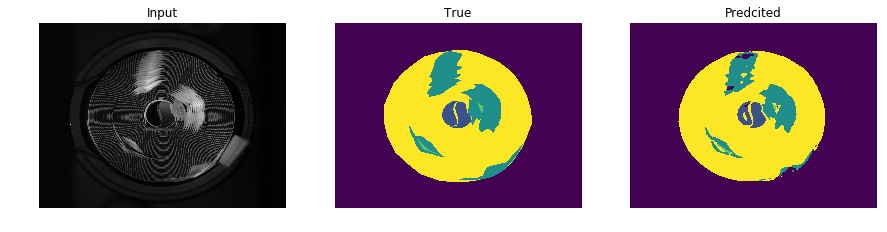

13에포크 이후의 예측 예시
Training Specifics: LR: 0.0001, Validation size: 10, Image size: (1440, 1920).
Current Accuracy: 0.9966152310371399
Validation Accuracy: 0.9836223721504211
18/18 [==============================] - 11s 618ms/step - loss: 0.0094 - accuracy: 0.9966 - val_loss: 0.0839 - val_accuracy: 0.9836
Epoch 14/50
 2/18 [==>...........................] - ETA: 3s - loss: 0.0095 - accuracy: 0.9967

KeyboardInterrupt: 

In [61]:
model_history_more = model.fit(train_ds, 
                          epochs=50,
                          validation_data = val_ds,
                          callbacks=[DisplayCallback()],)                               

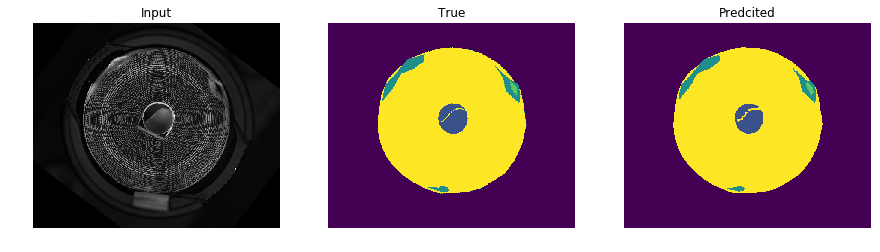

20에포크 이후의 예측 예시
Current Accuracy: 0.9950234293937683
Validation Accuracy: 0.9870858788490295
10/30 [=========>....................] - 2s 199ms/step - loss: 0.0136 - accuracy: 0.9950 - val_loss: 0.1294 - val_accuracy: 0.9871


In [43]:
finetune_history = model.fit(x= train_x[NUM_VAL:],
                          y= train_y[NUM_VAL:], 
                          batch_size = BATCH,
                          steps_per_epoch = STEPS_PER_EPOCH,
                          epochs=F_EPOCHS,
                          validation_data = (train_x[:NUM_VAL], train_y[:NUM_VAL], sample_weights[:NUM_VAL]),
                          callbacks=[DisplayCallback()],
                          sample_weight=sample_weights[NUM_VAL:])    

In [ ]:
"""
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
"""

"\n%tensorflow_version 2.x\nimport tensorflow as tf\ndevice_name = tf.test.gpu_device_name()\nif device_name != '/device:GPU:0':\n  raise SystemError('GPU device not found')\nprint('Found GPU at: {}'.format(device_name))\n"

WITH FINETUNING

In testing Mode...


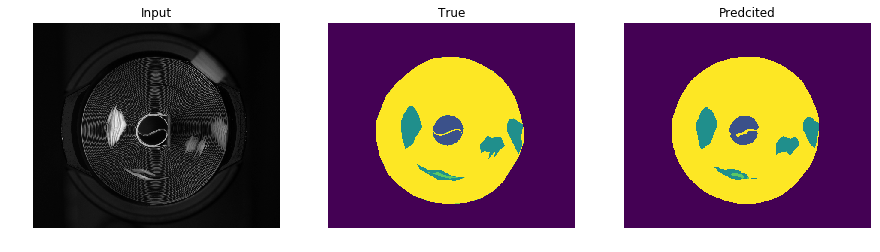

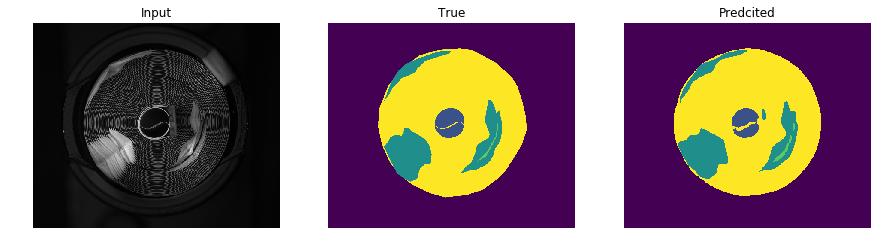

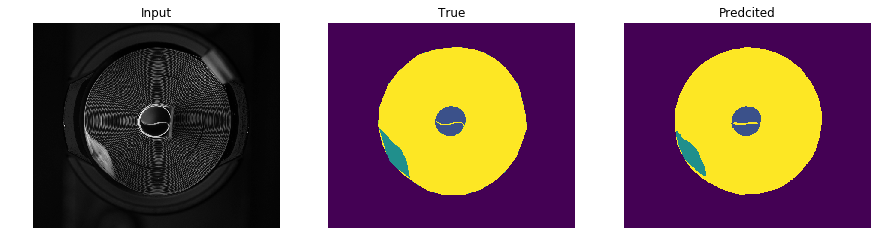

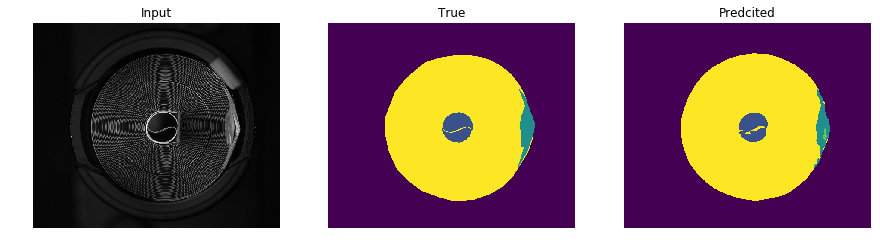

In [44]:
show_predictions(test_mode=True, x=test_x, y=test_y, num=4)

In [45]:
pred_mask = model.predict(test_x, batch_size=1)
aaa = create_mask(pred_mask, num=3)
dd = tf.one_hot(aaa, 5)
print(dd.shape)

(480, 576, 1, 5)


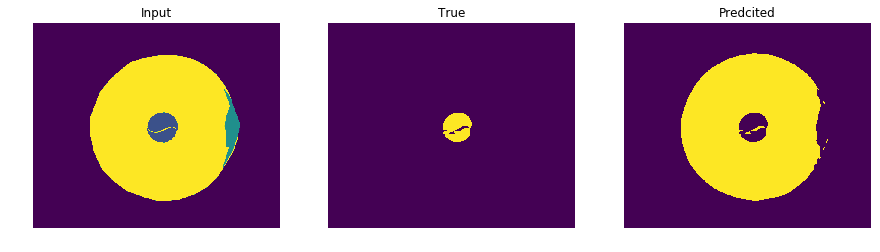

In [46]:
display([test_y[3], dd[:,:,:,1], dd[:,:,:,4]]) 
# 0 shows background, 1shows hole 2 shows "pushed", 3shows "Stamped", 4shows inner circle

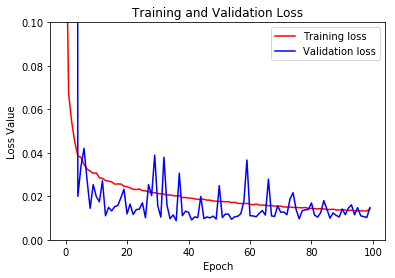

In [39]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 0.1])
plt.legend()
plt.show()

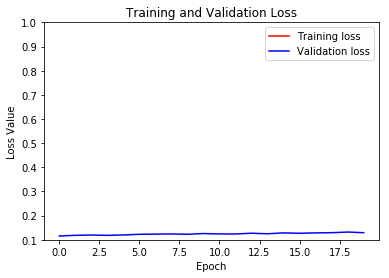

In [53]:
loss = finetune_history.history['loss']
val_loss = finetune_history.history['val_loss']

epochs = range(F_EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0.1, 1])
plt.legend()
plt.show()

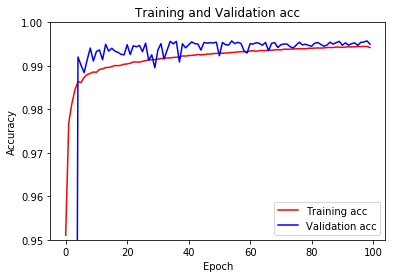

In [40]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.95,1])
plt.legend()
plt.show()

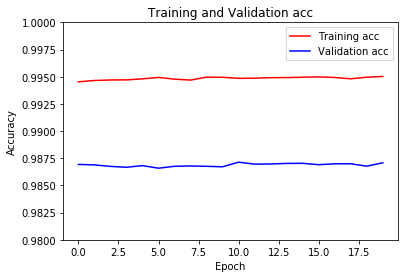

In [55]:
acc = finetune_history.history['accuracy']
val_acc = finetune_history.history['val_accuracy']

epochs = range(F_EPOCHS)

plt.figure()
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.98,1])
plt.legend()
plt.show()

In [111]:
print("Training accuracy at the last epoch is:", np.round(model_history.history['accuracy'][-1],3))

Training accuracy at the last epoch is: 0.996


In [48]:
print("Training accuracy (after finetuning) at the last epoch is:", np.round(finetune_history.history['accuracy'][-1],3))

Training accuracy (after finetuning) at the last epoch is: 0.993


Saving Model for use in Inference

In [41]:
model.save('saved_model_1025_{}_{}'.format(IMG_SIZE, LR))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model_1025_(1200, 1392)_0.001/assets
